In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


##Grabs the GoldCode module from the root of the repo
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from GoldCode import GoldCode
from GPSData import IQData

In [58]:
data = IQData()

# Need these to pass to importFile module
fs = 4.092*10**6 # Sampling Frequency [Hz]
NumberOfMilliseconds = 5
SampleLength = NumberOfMilliseconds*10**(-3)
BytesToSkip = 100000

#data.importFile('../resources/test.max', fs, SampleLength, BytesToSkip)
data.importFile('../resources/JGPS@04.559925043', fs, SampleLength, BytesToSkip)


Opening a file.
File handle is: 66.
Total Samples to read: 20460
Total Bytes read: 10230.
Which equals 20460 IQ pairs.
Sample Length: 0.005000 seconds.
File is now closed.


In [59]:
def makWav(freqHz, phaseDeg, samples, fs = 4.092*10**6):
    #Initialize terms
    freq = np.exp(1j * 2 * np.pi * (freqHz/fs))
    
    pOffset = np.deg2rad(phaseDeg) 

    phase = np.exp(1j * pOffset)

    #Init samples
    wav = np.zeros(samples, dtype = 'complex')

    
    for n, w in enumerate(wav):
        wav[n] = phase
        phase = phase * freq
    
    return wav

In [60]:
wav1 = makWav(2000, 0, 4000)
wav2 = makWav(-2000, 0 , 4000)
wavconj = np.conj(wav1)

#Choose which satellite's C/A code is generated
Satellite = 15

# Create list of C/A code Taps, for simpler sat selection",
sat = [(1,5),(2,6),(3,7),(4,8),(0,8),(1,5),(0,7),(1,8),(2,9),(1,2),(2,3),(4,5),(5,6),(6,7),(7,8),(8,9),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(0,2),(3,5),(4,6),(5,7),(6,8),(7,9),(0,5),(1,6),(2,7),(3,8),(4,9),(3,9),(0,6),(1,7),(3,9)]
CodeGen = GoldCode(sat[Satellite - 1]) 
CACode = CodeGen.getCode(1000, samplesPerChip = 4)

wavmod = wav1 * CACode

/usr/lib/python3/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


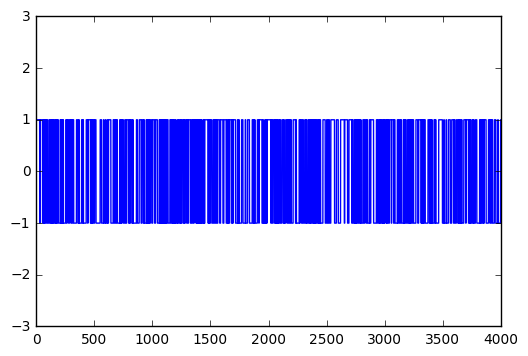

In [61]:
plt.plot(wavmod * wavconj)
plt.ylim([-3,3])
plt.show()

In [62]:
incWav= data.CData

#Logging Vectors
refWave = np.zeros(len(incWav), dtype='complex')
m = np.zeros(len(incWav))
discriminator = np.zeros(len(incWav))
rf = np.zeros(len(incWav), dtype = 'complex')


#Initialize vars
freqHz = 3100
baseF = np.exp(1j * 2 * np.pi * (freqHz/fs))
refFreq = baseF #Initial frequency

refphase = 1 + 0j #Initial phase

refWave[0] = refphase

adjustment = 0
oldErr = 0
oldRef = 0

#iterate over every sample and adjust
for n, samp in enumerate(incWav):
    #Mix
    mixed = incWav[n] / refWave[n]
    #m[n] = mixed
    
    #Check discriminator
    d = np.angle(mixed) / (2*np.pi)
    discriminator[n] = d #Save discriminator
    
    
    #Adjust frequency
    adjustment = oldRef + (d - oldErr) * (10) + d * 292
    refFreq = baseF +  adjustment     
    oldRef = adjustment
    
    oldErr = d
    
    #Calculate next reference frequency sample
    if (n<len(incWav)-1):
        rf[n]= refFreq
        refWave[n + 1] = refWave[n] * np.exp(1j * 2 * np.pi * (refFreq/fs))


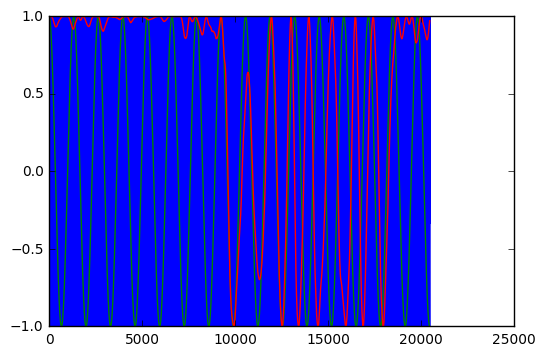

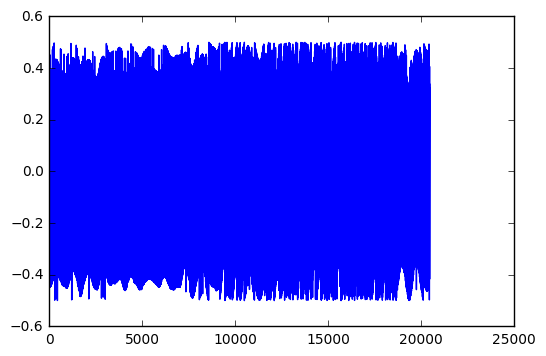

In [63]:
referenceWave = makWav(3100, 0, len(data.CData))

plt.plot(np.real(data.CData))
plt.plot(np.real(referenceWave))
#plt.plot(np.imag(data.CData))
plt.plot(np.real(refWave))
plt.show()

plt.plot(discriminator)
plt.show()